# Imports

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from nilearn.masking import apply_mask,intersect_masks
from nilearn.plotting import plot_glass_brain
from nilearn.image import load_img,index_img

C:\Python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Python38\lib\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
C:\Python38\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Python38\lib\site-packages\nilearn\datasets\__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


# Loading data

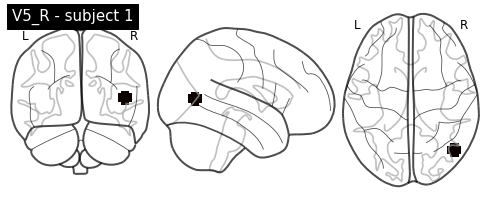

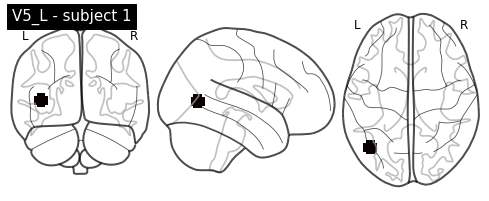

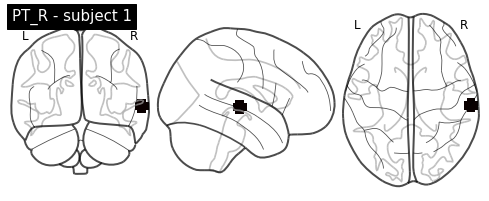

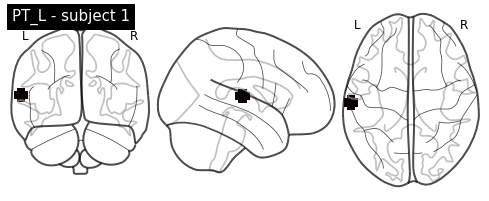

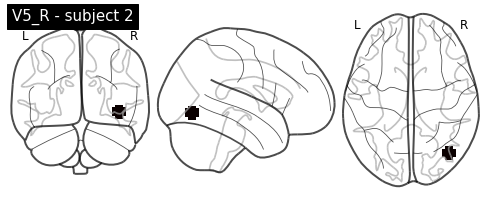

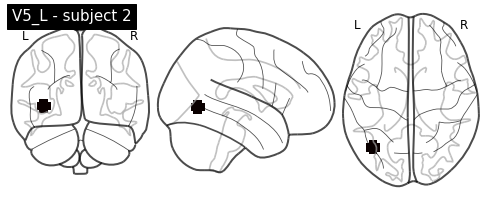

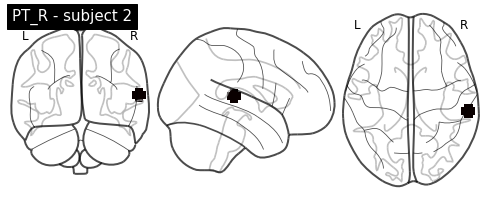

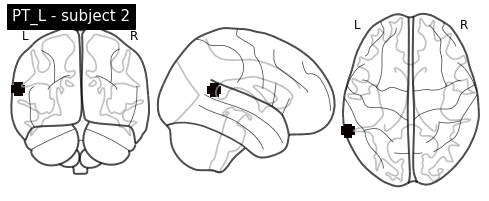

In [2]:
nb_subjects = 2
classes = ['vis_U','vis_D','vis_R','vis_L','aud_U','aud_D','aud_R','aud_L']
masks_names = ['V5_R','V5_L','PT_R','PT_L']

t_maps = [None]*nb_subjects
beta_maps = [None]*nb_subjects
masks = [None]*nb_subjects
masks_full = [None]*nb_subjects

for i in range(nb_subjects): 
    t_maps[i] = load_img("brain_maps/sub"+str(i+1)+"_4D_t_maps_0.nii")
    beta_maps[i] = load_img("brain_maps/sub"+str(i+1)+"_4D_beta_0.nii")
    masks_full[i] = load_img("masks/WHOLE_sub"+str(i+1)+".nii")
    masks[i] = dict()
    for name in masks_names:
        masks[i][name] = load_img("masks/ROI_sub"+str(i+1)+"_"+name+".nii")
        plot_glass_brain(masks[i][name], title = name+" - subject "+str(i+1))


# Motion decoding

In [3]:
# 1. create and apply apply masks 
masks_vis = [None]*nb_subjects
masks_aud = [None]*nb_subjects
length = int(t_maps[0].shape[3]/2)
t_maps_masked_V5_R = [None]*nb_subjects
t_maps_masked_V5_L = [None]*nb_subjects
t_maps_masked_PT_R = [None]*nb_subjects
t_maps_masked_PT_L = [None]*nb_subjects
t_maps_full_vis = [None]*nb_subjects
t_maps_full_aud = [None]*nb_subjects

for i in range(nb_subjects):
    t_maps_masked_V5_R[i] = apply_mask(index_img(t_maps[i],range(length)),masks[i]['V5_R'])
    t_maps_masked_V5_L[i] = apply_mask(index_img(t_maps[i],range(length)),masks[i]['V5_L'])

    t_maps_masked_PT_R[i] = apply_mask(index_img(t_maps[i],range(length,2*length)),masks[i]['PT_R'])
    t_maps_masked_PT_L[i] = apply_mask(index_img(t_maps[i],range(length,2*length)),masks[i]['PT_L'])

    t_maps_full_vis[i] = apply_mask(index_img(t_maps[i],range(length)),masks_full[i])
    t_maps_full_aud[i] = apply_mask(index_img(t_maps[i],range(length,2*length)),masks_full[i])


In [4]:
# 2. create labels
class_labels = [None]*(length*2)
nb_runs = 12

for i in range(length*2) : 
    class_labels[i]=classes[i // nb_runs]
    
labels_vis = np.array(class_labels[:length])
labels_aud = np.array(class_labels[length:])

In [5]:
# 3. decode
def cross_validate(model,maps,labels,n_splits,descriptor):
    kf = sklearn.model_selection.KFold(n_splits=n_splits,shuffle=True,random_state=1) 
    scores=[]

    for i in range(nb_subjects) :
        acc=0
        for train_index, test_index in kf.split(maps[i]):
            X_train,X_test = maps[i][train_index],maps[i][test_index]
            y_train,y_test = labels[train_index],labels[test_index]

            model.fit(X_train,y_train)
            score = model.score(X_test,y_test)
            acc += score

        scores.append(acc/n_splits)

    for i in range(nb_subjects) :
        print(descriptor+" - cv score for subject "+str(i+1)+" is "+str(scores[i]))
        
    return scores

#### Visual motion 

In [6]:
classifier_vis = sklearn.svm.SVC(C=math.inf,kernel='linear') #default parameters, there is clearly improvements to be made here
scores_vis_masked = cross_validate(classifier_vis,t_maps_masked_V5_R,labels_vis,12,"V5 R")

classifier_vis = sklearn.svm.SVC(C=math.inf,kernel='linear') #default parameters, there is clearly improvements to be made here
scores_vis_masked = cross_validate(classifier_vis,t_maps_masked_V5_L,labels_vis,12,"V5 L")

V5 R - cv score for subject 1 is 0.1875
V5 R - cv score for subject 2 is 0.25
V5 L - cv score for subject 1 is 0.20833333333333334
V5 L - cv score for subject 2 is 0.125


In [7]:
scores_vis_full = cross_validate(classifier_vis,t_maps_full_vis,labels_vis,12,"Whole brain")

Whole brain - cv score for subject 1 is 0.10416666666666667
Whole brain - cv score for subject 2 is 0.08333333333333333


#### Auditory motion 

In [9]:
classifier_aud = sklearn.svm.SVC(C=math.inf,kernel='linear') #default parameters, there is clearly improvements to be made here
scores_aud_masked = cross_validate(classifier_aud,t_maps_masked_PT_R,labels_aud,12,"PT R")

classifier_aud = sklearn.svm.SVC(C=math.inf,kernel='linear') #default parameters, there is clearly improvements to be made here
scores_aud_masked = cross_validate(classifier_aud,t_maps_masked_PT_L,labels_aud,12,"PT L")

PT R - cv score for subject 1 is 0.25
PT R - cv score for subject 2 is 0.20833333333333334
PT L - cv score for subject 1 is 0.20833333333333334
PT L - cv score for subject 2 is 0.1875
